In [1]:
pip install opencv-python


  Using cached opencv_python-4.10.0.84-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python-4.10.0.84-cp37-abi3-win_amd64.whl (38.8 MB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import PIL
from skimage.filters import frangi
from skimage import exposure
from skimage.filters import frangi, apply_hysteresis_threshold

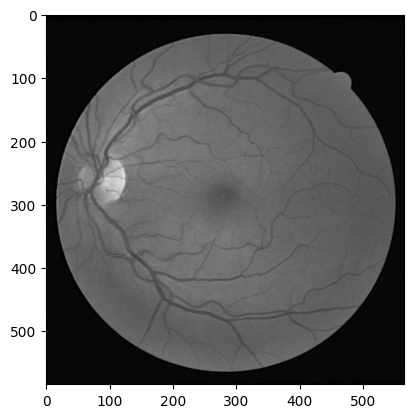

In [3]:
img_path = r'C:\Users\Acer\Documents\IIP\retina_images_01_10\retina_images_01_10'
img = cv2.imread(os.path.join(img_path,'1.tif'),cv2.IMREAD_COLOR)
imgGreen = img[:,:,1]
plt.imshow(imgGreen,cmap='gray', vmin=0, vmax=255)

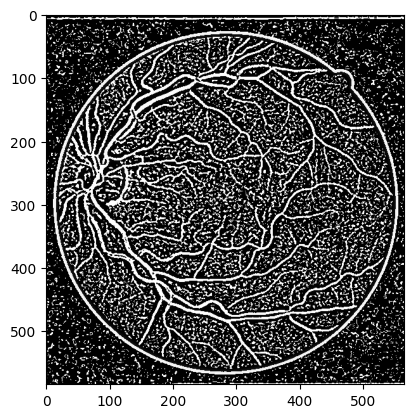

In [4]:
blur1 = cv2.GaussianBlur(imgGreen,(5,5),0)
blur2 = cv2.GaussianBlur(imgGreen,(11,11),0)
DoG = blur1-blur2;
plt.imshow(DoG,cmap='gray', vmin=0, vmax=255)

dtype: uint8, shape: (584, 565), min: 0, max: 255


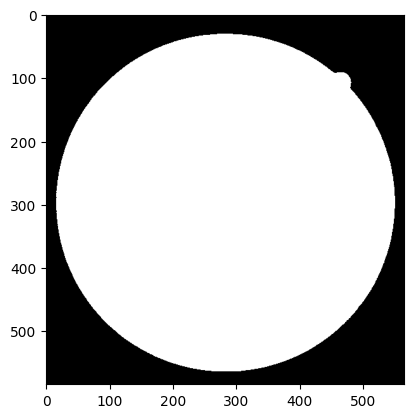

In [5]:
mask_path = r'C:\Users\Acer\Documents\IIP\mask_images\mask_images'
mask = PIL.Image.open(os.path.join(mask_path,'1.tif'))
mask = np.array(mask)
print(f'dtype: {mask.dtype}, shape: {mask.shape}, min: {np.min(mask)}, max: {np.max(mask)}')
plt.imshow(mask,cmap='gray', vmin=0, vmax=255)


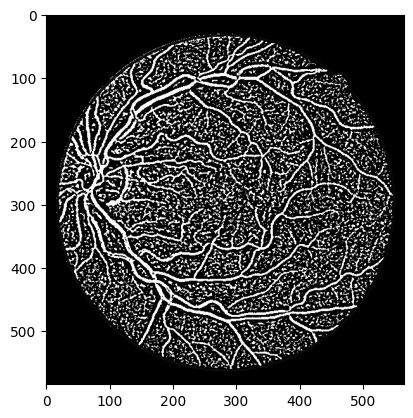

In [6]:
mask_DoG = np.multiply(DoG,mask/255)
plt.imshow(mask_DoG,cmap='gray', vmin=0, vmax=255)

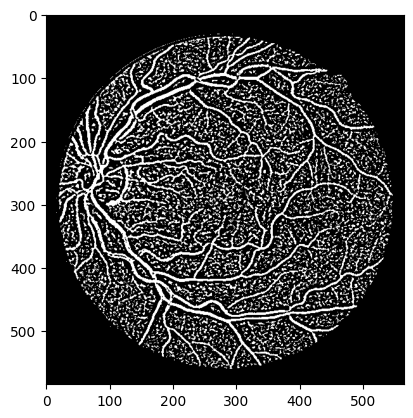

In [7]:
thres_DoG = mask_DoG>220
plt.imshow(thres_DoG*255,cmap='gray', vmin=0, vmax=255)

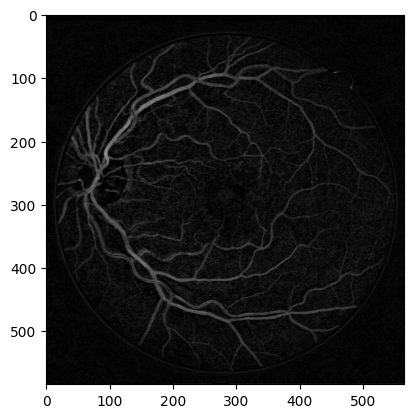

In [8]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(16, 16))
img_clahe = clahe.apply(imgGreen)
kernel_size = 15  # Adjust kernel size based on vessel width
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
black_tophat = cv2.morphologyEx(img_clahe, cv2.MORPH_BLACKHAT, kernel)# Apply black tophat operation on image that undergone CLAHE
plt.imshow(black_tophat,cmap='gray', vmin=0, vmax=255)

C:\Users\Acer\AppData\Local\Temp\ipykernel_34168\735259019.py:4: UserWarning: Use keyword parameter `sigmas` instead of `scale_range` and `scale_range` which will be removed in version 0.17.
  frangi_result = frangi(imgGreen, scale_range=(0.5, 10), scale_step=1.5, beta=15)


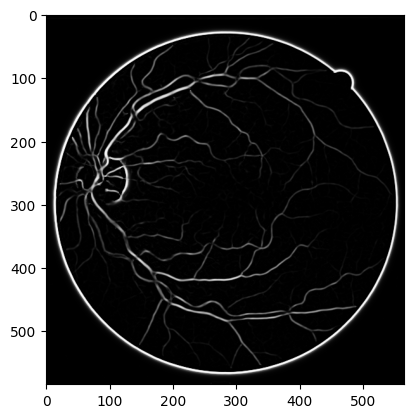

In [20]:
_, thres = cv2.threshold(black_tophat, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Frangi filtering
frangi_result = frangi(imgGreen, scale_range=(0.5, 10), scale_step=1.5, beta=15)
plt.imshow(frangi_result, cmap='gray', vmin=0, vmax=1)

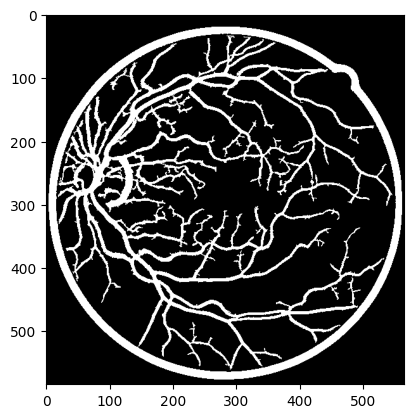

In [21]:
low = 0.01 # Adjust low and high thresholds as needed
high = 0.5
binary_image = apply_hysteresis_threshold(frangi_result, low, high) # Apply hysteresis thresholding to the binary image produced by frangi
plt.imshow(binary_image, cmap='gray', vmin=0, vmax=1)

In [2]:
# Load image paths and other necessary data
img_path_1 = r'retina_images_01_10\retina_images_01_10'
img_path_2 = r'retina_images_11_20\retina_images_11_20'
mask_path = r'mask_images\mask_images'
label_path = r'label_images\label_images'

P_total, N_total, T_total = 0., 0., 0.

# Change the range according to the number of retina images.
for i in range(1, 21):
    # Load input image
    if i < 11:
        img = cv2.imread(os.path.join(img_path_1, str(i) + '.tif'), cv2.IMREAD_COLOR)
    else:
        img = cv2.imread(os.path.join(img_path_2, str(i) + '.tif'), cv2.IMREAD_COLOR)

    
    imgGreen = img[:,:,1]


    # Enhance contrast using CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(16, 16))
    img_clahe = clahe.apply(imgGreen)

    kernel_size = 15  # Adjust kernel size based on vessel width
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
    black_tophat = cv2.morphologyEx(img_clahe, cv2.MORPH_BLACKHAT, kernel)# Apply black tophat operation on image that undergone CLAHE
    
    # median filter(3, 3)
    
    
    # Use Otsu's thresholding
    _, thres = cv2.threshold(black_tophat, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Frangi filtering
    frangi_result = frangi(imgGreen, scale_range=(0.5, 10), scale_step=1.5, beta=15)

    
    low = 0.01 # Adjust low and high thresholds as needed
    high = 0.5
    binary_image = apply_hysteresis_threshold(frangi_result, low, high) # Apply hysteresis thresholding to the binary image produced by frangi
    
    mask = np.array(PIL.Image.open(os.path.join(mask_path, str(i) + '.tif')))
    mask_thres = np.multiply(thres, mask / 255)
    mask_frangi = np.multiply(binary_image, mask / 255)
    
    # Multiply the results of Frangi filter after Otsu's thresholding and Blacktophat after Hysteresis thresholding
    combined = np.multiply(mask_frangi, mask_thres)

    # Load mask and label images
    mask = np.array(PIL.Image.open(os.path.join(mask_path, str(i) + '.tif')))
    mask_DoG = np.multiply(combined, mask / 255)
    thres_DoG = mask_DoG > 0  # Adjust threshold value as needed
    label = np.array(PIL.Image.open(os.path.join(label_path, str(i) + '.tif')))

    # Calculate evaluation metrics
    TP = sum(sum((label==255) & (thres_DoG==1) & (mask == 255)))
    TN = sum(sum((label==0) & (thres_DoG==0) & (mask == 255))) 
    FP = sum(sum((label==0) & (thres_DoG==1) & (mask == 255)))
    FN = sum(sum((label==255) & (thres_DoG==0) & (mask == 255)))
    P_total += TP/(TP+FN)
    N_total += TN/(TN+FP)
    T_total += (TP+TN)/(TP+FN+TN+FP)

    

# Calculate and print average evaluation metrics
print('P Average: ', P_total / 20)
print('N Average: ', N_total / 20)
print('T Average: ', T_total / 20)


C:\Users\Acer\AppData\Local\Temp\ipykernel_3684\3192179167.py:45: UserWarning: Use keyword parameter `sigmas` instead of `scale_range` and `scale_range` which will be removed in version 0.17.
  frangi_result = frangi(imgGreen, scale_range=(0.5, 10), scale_step=1.5, beta=15)


P Average:  0.6458968713369031
N Average:  0.9854959168032357
T Average:  0.9418937177535366
